In [4]:
import numpy as np
import pickle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import load_npz, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)


In [5]:
# Load preprocessed data
X_train = load_npz("X_train_sparse.npz")
X_test = load_npz("X_test_sparse.npz")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")


In [6]:
# Define dimensions for BTF, word n-grams, and char n-grams
btf_cols = 20000
wordtf_cols = 1000
chartf_cols = 500

# Split training features
X_btf_train = X_train[:, :btf_cols]
X_word_train = X_train[:, btf_cols:btf_cols + wordtf_cols]
X_char_train = X_train[:, btf_cols + wordtf_cols:]

# Split test features
X_btf_test = X_test[:, :btf_cols]
X_word_test = X_test[:, btf_cols:btf_cols + wordtf_cols]
X_char_test = X_test[:, btf_cols + wordtf_cols:]


In [15]:
def evaluate_model(model, X_train, y_train, X_test, y_test, title):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n=== {title} ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC:       {roc_auc:.4f}")

    # Confusion matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{title} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC Curve
    plt.figure(figsize=(4, 3))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title} - ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return model



=== LogReg on BoW + TF-IDF ===
Accuracy:  0.9746
Precision: 0.9661
Recall:    0.9807
F1 Score:  0.9734
AUC:       0.9937


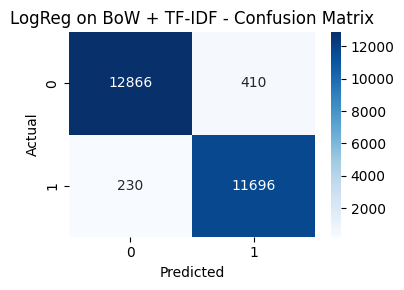

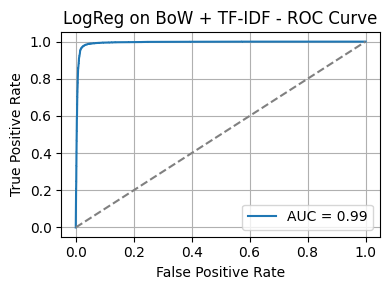


=== LogReg on Word n-grams + TF-IDF ===
Accuracy:  0.9551
Precision: 0.9445
Recall:    0.9616
F1 Score:  0.9530
AUC:       0.9904


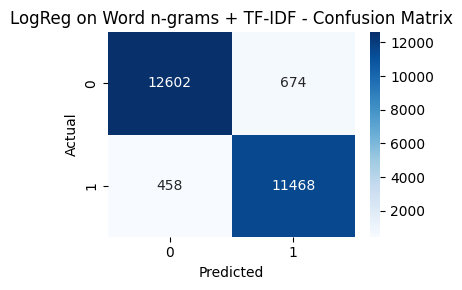

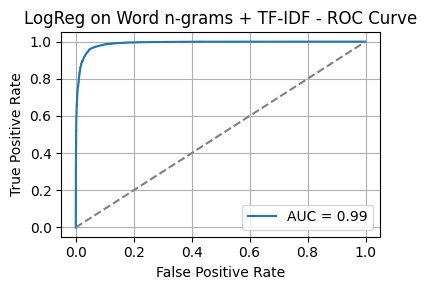


=== LogReg on Char n-grams + TF-IDF ===
Accuracy:  0.9055
Precision: 0.9028
Recall:    0.8969
F1 Score:  0.8998
AUC:       0.9666


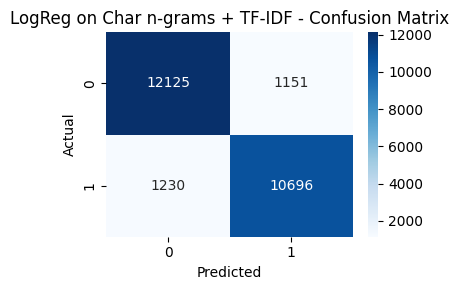

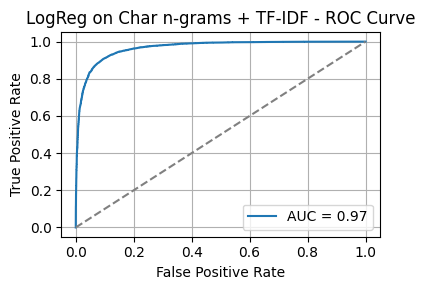

LogisticRegression(max_iter=1000)

In [16]:
# Logistic Regression on different feature sets
evaluate_model(LogisticRegression(max_iter=1000), X_btf_train, y_train, X_btf_test, y_test, "LogReg on BoW + TF-IDF")
evaluate_model(LogisticRegression(max_iter=1000), X_word_train, y_train, X_word_test, y_test, "LogReg on Word n-grams + TF-IDF")
evaluate_model(LogisticRegression(max_iter=1000), X_char_train, y_train, X_char_test, y_test, "LogReg on Char n-grams + TF-IDF")



=== LogReg on All Features Combined ===
Accuracy:  0.9798
Precision: 0.9735
Recall:    0.9840
F1 Score:  0.9787
AUC:       0.9955


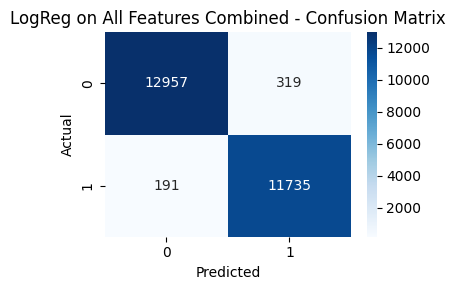

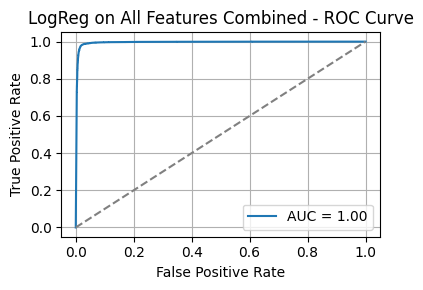

In [17]:
# Combine all feature sets
X_all_train = hstack([X_btf_train, X_word_train, X_char_train])
X_all_test = hstack([X_btf_test, X_word_test, X_char_test])

# Evaluate logistic regression on all features combined
all_feature = evaluate_model(
    LogisticRegression(max_iter=1000),
    X_all_train, y_train,
    X_all_test, y_test,
    "LogReg on All Features Combined"
)


# Model explainability

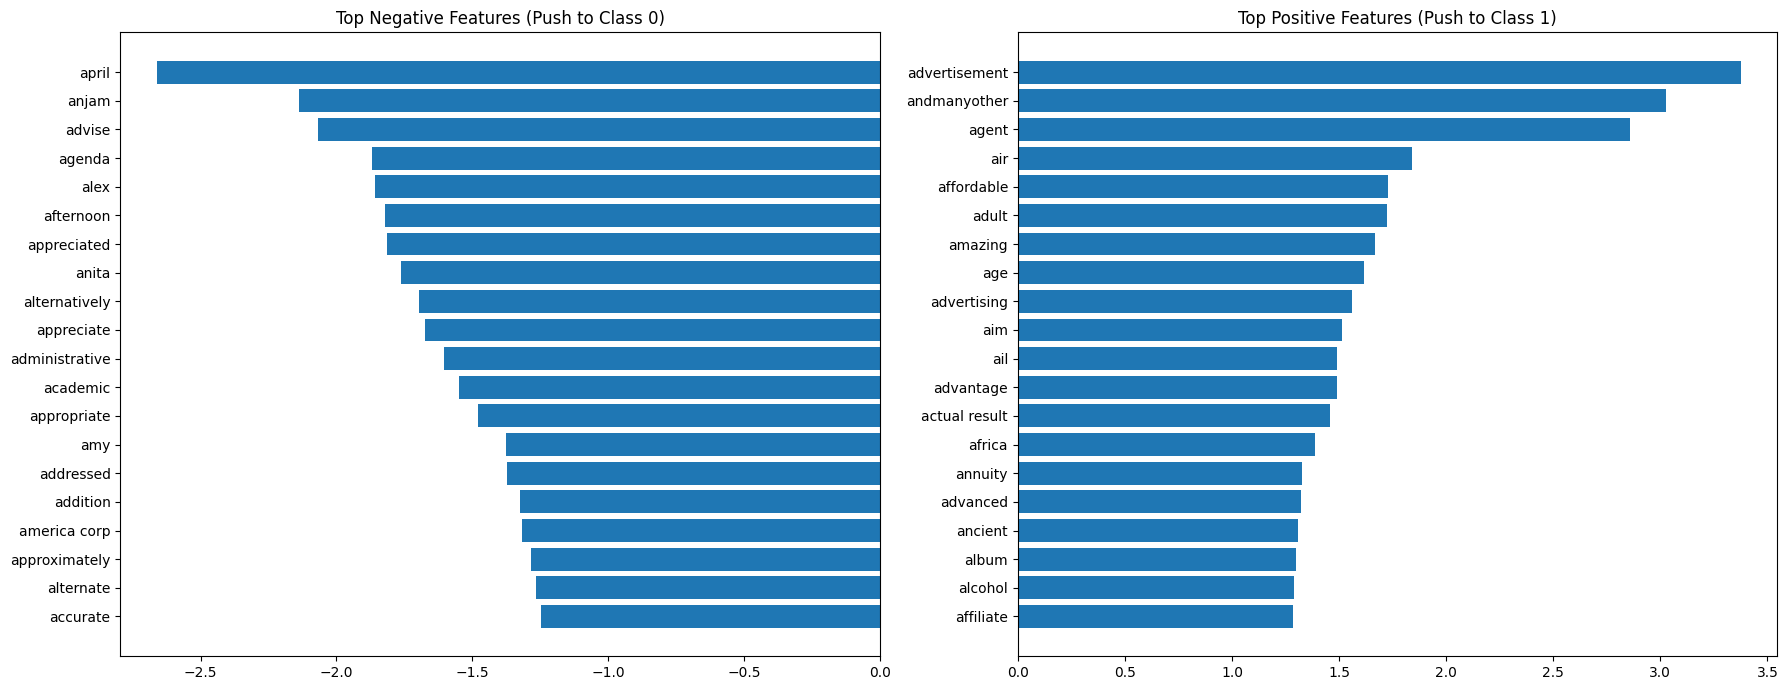

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack, vstack


X_bow_reduced = vstack([x[:, :500] for x in bow_tfidf_df["X_bow"].iloc[:3000]])
X_tfidf_reduced = vstack([x[:, :500] for x in bow_tfidf_df["X_tfidf"].iloc[:3000]])
X_btf_reduced = hstack([X_bow_reduced, X_tfidf_reduced])

y_btf_sample = bow_tfidf_df["label"].values[:3000]


feature_names_bow = bow_tfidf_dict["bow_vectorizer"].get_feature_names_out()[:500]
feature_names_tfidf = bow_tfidf_dict["tfidf_vectorizer"].get_feature_names_out()[:500]
feature_names = np.concatenate([feature_names_bow, feature_names_tfidf])


model = LogisticRegression(max_iter=1000)
model.fit(X_btf_reduced, y_btf_sample)


weights = model.coef_[0]
coef_tuples = list(zip(feature_names, weights))
coef_tuples.sort(key=lambda x: x[1])


top_n = 20
top_negative = coef_tuples[:top_n]
top_positive = coef_tuples[-top_n:]

fig, axs = plt.subplots(1, 2, figsize=(18, 7))

axs[0].barh([k for k, _ in top_negative], [v for _, v in top_negative])
axs[0].set_title("Top Negative Features (Push to Class 0)")
axs[0].invert_yaxis()

axs[1].barh([k for k, _ in reversed(top_positive)], [v for _, v in reversed(top_positive)])
axs[1].set_title("Top Positive Features (Push to Class 1)")
axs[1].invert_yaxis()

plt.tight_layout()
plt.show()
